In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/titanic/"

In [4]:
!ls {PATH}

test.csv  train.csv


In [5]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [6]:
df_raw.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
df_raw['Surname'] = df_raw['Name'].str.split(',').str[0]

In [8]:
df_raw.head()
df_raw = df_raw.drop('Name', axis=1)
train_cats(df_raw)

In [9]:
df_raw.isnull().sum().sort_index()/len(df_raw)

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Surname        0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

In [10]:
os.makedirs('tmp', exist_ok=True)
df_raw.reset_index().to_feather('tmp/titanic-raw')

In [11]:
df_raw = pd.read_feather('tmp/titanic-raw')

In [12]:
df, y, nas = proc_df(df_raw, 'Survived')
df['Fare_na']=False

In [13]:
set_rf_samples(20000)

In [14]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(df, y)
m.score(df,y)

/home/amit/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/amit/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.9371492704826038

In [15]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 500  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((391, 14), (391,), (500, 14))

In [16]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
m.score(X_valid, y_valid)

/home/amit/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.786

In [17]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 0.0, 1)

In [18]:
preds.shape

(10, 500)

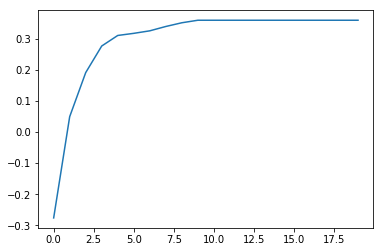

In [19]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(20)]);

In [20]:
m = RandomForestClassifier(n_estimators=150, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
m.score(X_valid, y_valid)

/home/amit/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/amit/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.788

In [21]:
set_rf_samples(20000)

In [22]:
m = RandomForestClassifier(n_estimators=150, min_samples_leaf=5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
m.score(X_valid, y_valid)

CPU times: user 347 ms, sys: 11.5 ms, total: 358 ms
Wall time: 260 ms


/home/amit/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/amit/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.786